In [1]:
import wandb
import pandas as pd
import numpy as np
from scipy.stats import binomtest

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
api = wandb.Api()

In [3]:
runs = api.runs(path="seas/vmcts")

In [4]:
df = pd.DataFrame()

groups = ["temp-sweep-2"]

for run in runs:
    if run.group in groups:
        history = run.summary
        # history = run.history(samples=1000, 
        keys=[
                            "final/pass_at_5000",
                            "final/pass_at_2000",
                            "final/pass_at_1000",
                            "final/pass_at_500",
                            "final/n_tokens",
                            "final/width",
                            "final/depth",
                            "final/total_nodes",
                            "final/max_value",
                            "final/min_value",
                            ]
    
        run_dict = {}
        run_dict["id"] = run.id
        run_dict["group"] = run.group
        run_dict["temp"] = run.config["model_arg_temp"]
        run_dict["topp"] = run.config["model_arg_topp"]
        run_dict["seed"] = run.config["seed"]

        if any([key not in history for key in keys]):
            continue
        for key in keys:
            run_dict[key] = history[key]

        run_df = pd.DataFrame(run_dict, index=[0])
        df = pd.concat([df, run_df])

In [5]:
df.head()

,id,group,temp,topp,seed,final/pass_at_5000,final/pass_at_2000,final/pass_at_1000,final/pass_at_500,final/n_tokens,final/width,final/depth,final/total_nodes,final/max_value,final/min_value
0,d5j2jvpw,temp-sweep-2,0.8,0.95,26,1,1,0,0,1288,2,17,32,6,-6
0,bdzaq1ts,temp-sweep-2,1.2,0.95,25,1,1,0,0,1132,2,17,32,7,-3
0,ut0xwo07,temp-sweep-2,1.0,0.95,23,1,1,0,0,1449,3,9,18,5,-17
0,tybzdlbq,temp-sweep-2,1.4,0.95,13,1,0,0,0,3931,8,32,150,16,-39
0,0k54yg9o,temp-sweep-2,1.4,0.95,98,1,1,1,0,530,2,26,50,21,-1


In [6]:
len(df)

500

In [7]:
for temp in df.temp.unique():
    print(len(df[df["temp"] == temp]), temp)

100 0.8
100 1.2
100 1.0
100 1.4
100 0.6


In [8]:
def confidence_interval(successes, trials=100):
    ci = binomtest(successes, trials).proportion_ci(confidence_level=0.95, method="wilson")
    return ci.low, ci.high

In [9]:
def compute_pass_at_t_and_ci(df, t):
    passes = (df[f"final/n_tokens"] <= t).sum()
    total = len(df)
    pass_at_t = passes / total
    low, high = confidence_interval(passes, total)
    return pass_at_t, low, high

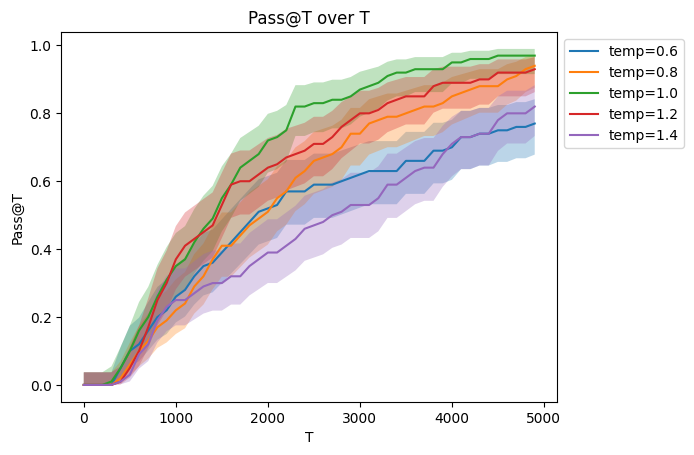

In [10]:
ts = np.arange(0, 5000, 100)

for temp in sorted(df["temp"].unique()):
    config_df = df[(df["temp"] == temp) & (df["topp"] == '0.95')]
    
    success_rates, lows, highs = [], [], []
    for t in ts:
        success_rate, low, high = compute_pass_at_t_and_ci(config_df, t)
        success_rates.append(success_rate)
        lows.append(low)
        highs.append(high)

    plt.plot(ts, success_rates, label=f"temp={temp}")
    plt.fill_between(ts, lows, highs, alpha=0.3)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("T")
plt.ylabel("Pass@T")
plt.title("Pass@T over T")
plt.show()

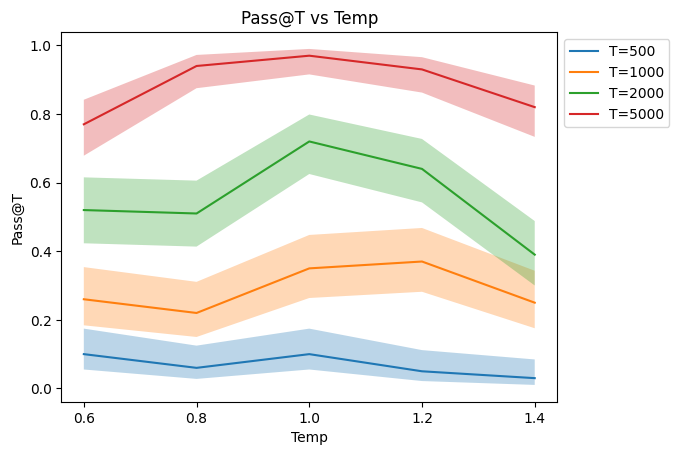

In [11]:
temps = sorted(df["temp"].unique())

for T in [500, 1000, 2000, 5000]:
    config_df = df
    success_rates, lows, highs = [], [], []
    for temp in temps:
        config_df_2 = config_df[config_df["temp"] == temp]
        if config_df_2.empty:
            success_rate, low, high = np.nan, np.nan, np.nan
        else:
            success_rate, low, high = compute_pass_at_t_and_ci(config_df_2, T)
        success_rates.append(success_rate)
        lows.append(low)
        highs.append(high)

    plt.plot(temps, success_rates, label=f"T={T}")
    plt.fill_between(temps, lows, highs, alpha=0.3)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("Temp")
plt.ylabel(f"Pass@T")
plt.title(f"Pass@T vs Temp")
plt.show()